In [1]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config


In [2]:
# Example tensor
x = torch.randn(128, 1, 28, 28)

# Extract the first element while maintaining dimensions
first_element = x[0:1, :, :, :]

# Verify the shape of the resulting tensor
print(first_element.shape)  # Ou

torch.Size([1, 1, 28, 28])


# RAM model

In [3]:
# paths
plot_dir = "../plots/"
data_dir = "../data/"

# load images
imgs = []
paths = [data_dir + "./lenna.jpg", data_dir + "./cat.jpg"]
for i in range(len(paths)):
    img = utils.img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute((0, 3, 1, 2))

B, C, H, W = imgs.shape
l_t_prev = torch.FloatTensor(B, 2).uniform_(-1, 1)
h_t_prev = torch.zeros(B, 256)

ram = model.RecurrentAttention(64, 3, 2, C, 128, 128, 0.11, 256, 10)
h_t, l_t, _, _ = ram(imgs, l_t_prev, h_t_prev)

assert h_t.shape == (B, 256)
assert l_t.shape == (B, 2)


3 64 3 36864


In [4]:
h_t.shape

torch.Size([2, 256])

In [5]:
l_t.shape

torch.Size([2, 2])

In [6]:
l_t

tensor([[-0.0165, -0.0640],
        [-0.0728,  0.2296]])

In [7]:
h_t_prev.shape

torch.Size([2, 256])

# Glimpse Test

(1, 900)


(10, 30, 3)

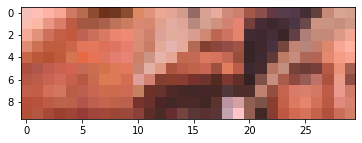

In [8]:
def bounding_box(x, y, size, color="w"):
    x = int(x - (size / 2))
    y = int(y - (size / 2))
    rect = patches.Rectangle(
        (x, y), size, size, linewidth=1, edgecolor=color, fill=False
    )
    return rect


# https://stackoverflow.com/questions/10657383/stitching-photos-together
def merge_images(image1, image2):
    """Merge two images into one, displayed side by side.
    """
    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new("RGB", (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result


# paths
data_dir = "../data/"


# load images
imgs = []
paths = [data_dir + "./lenna.jpg"]
for i in range(len(paths)):
    img = img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute(0,3, 1, 2)

#loc = torch.Tensor(2, 2).uniform_(-1, 1)
loc = torch.from_numpy(np.array([[0.0, 0.0], [0.0, 0.0]]))

num_patches = 3
scale = 4
patch_size = 10

ret = Retina(g=patch_size, k=num_patches, s=scale)
glimpse = ret.foveate(imgs, loc).data.numpy()

print(glimpse.shape)

glimpse = np.reshape(glimpse, [1, num_patches, 3, patch_size, patch_size])
glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])

merged = []
for i in range(len(glimpse)):
    g = glimpse[i]
    g = list(g)
    g = [array2img(l) for l in g]
    res = reduce(merge_images, list(g))
    merged.append(res)

merged = [np.asarray(l, dtype="float32") / 255.0 for l in merged]

plt.imshow(merged[0])

merged[0].shape


# Glimpse Test Single MNIST Example

In [9]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)


In [10]:
dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

torch.Size([1, 28, 28])


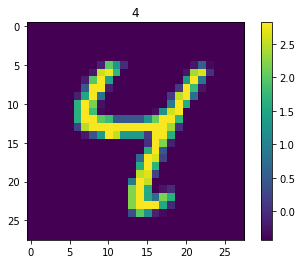

In [11]:
image, label = dataset[6]
plt.imshow(image[0])
plt.colorbar()
plt.title(label)
print(image.shape)

Text(0.5, 1.0, '1')

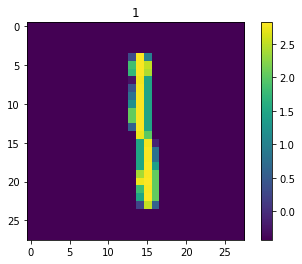

In [12]:
image, label = dataset[1236]
plt.imshow(image[0])
plt.colorbar()
plt.title(label)

In [13]:
image.shape

torch.Size([1, 28, 28])

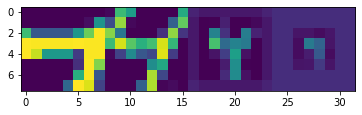

In [14]:
mnistImage, label = dataset[6]
mnistImage = mnistImage.unsqueeze(1)

#loc = torch.Tensor(2, 2).uniform_(-1, 1)
loc = torch.from_numpy(np.array([[0.0, 0.0]]))

num_patches = 4
scale = 2
patch_size = 8

ret = Retina(g=patch_size, k=num_patches, s=scale)
glimpse = ret.foveate(mnistImage, loc).data.numpy()


glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])


concat_glimpse = np.concatenate([glimpse[0, i] for i in range(glimpse.shape[1])], axis=1)
plt.imshow(concat_glimpse)

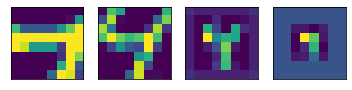

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=glimpse.shape[1])
for i, ax in enumerate(axs.flat):
    axs[i].imshow(glimpse[0,i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show()

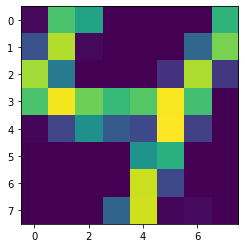

In [16]:
plt.imshow(glimpse[0,1])


# Do single episode using trained RAM model

In [17]:
#load the model (code from load_checkpoint function in trainer.py):

filename = "../ckpt/ram_6_8x8_1_model_best.pth.tar"

ckpt = torch.load(filename) #model

In [18]:
# build RAM model
config, unparsed = get_config()

ram = model.RecurrentAttention(
    config.patch_size,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)

ram.load_state_dict(ckpt["model_state"])

1 8 1 64


<All keys matched successfully>

In [19]:
print(" Model data:\n patch size: " + str(config.patch_size) + 
    "\n num_patches: " + str(config.num_patches)+
    "\n glimpse_scale: " + str(config.glimpse_scale)+
    "\n num_channels: " + str(1)+
    "\n loc_hidden: " + str(config.loc_hidden)+
    "\n glimpse_hidden: " + str(config.glimpse_hidden)+
    "\n std: " + str(config.std)+
    "\n hidden_size: " + str(config.hidden_size)+
    "\n num_classes: " + str(10))

 Model data:
 patch size: 8
 num_patches: 1
 glimpse_scale: 1
 num_channels: 1
 loc_hidden: 128
 glimpse_hidden: 128
 std: 0.05
 hidden_size: 256
 num_classes: 10


In [20]:
ram

RecurrentAttention(
  (sensor): GlimpseNetwork(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=2, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=128, out_features=256, bias=True)
  )
  (rnn): CoreNetwork(
    (i2h): Linear(in_features=256, out_features=256, bias=True)
    (h2h): Linear(in_features=256, out_features=256, bias=True)
  )
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=2, bias=True)
  )
  (classifier): ActionNetwork(
    (fc): Linear(in_features=256, out_features=10, bias=True)
  )
  (baseliner): BaselineNetwork(
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [21]:
def reset():
    h_t = torch.zeros(
        1,
        config.hidden_size,
        dtype=torch.float,
        requires_grad=True,
    )
    l_t = torch.FloatTensor(
        1, 2).uniform_(-1, 1)
    l_t.requires_grad = True

    return h_t, l_t

In [22]:
#print(label)
#print("shape: " + str(mnistImage.shape))
#plt.imshow(mnistImage[0,0], cmap="gray")

In [23]:
mnistImage, label = dataset[98]
mnistImage = mnistImage.unsqueeze(1)

#do 10 glimpses
h_t, l_t = reset()

loc_list = []
for t in range(5):
    # forward pass through model
    h_t, l_t, b_t, p = ram(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))

Prediction: 6, actual: 6


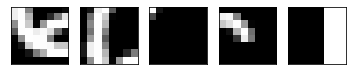

In [24]:
num_patches = config.num_patches
scale = config.glimpse_scale
patch_size = config.patch_size

glimpses = []
for loc in loc_list:
    ret = Retina(g=patch_size, k=num_patches, s=scale)
    glimpse = ret.foveate(mnistImage, loc).data.numpy()
    glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])
    glimpses.append(glimpse)

    
fig, axs = plt.subplots(nrows=1, ncols=len(glimpses))
for i, ax in enumerate(axs.flat):
    axs[i].imshow(glimpses[i][0][0], cmap="gray")
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show()

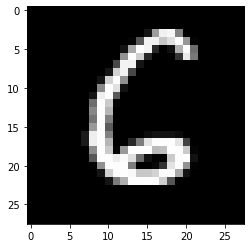

In [25]:
plt.imshow(mnistImage[0][0], cmap="gray")

# Build RAM which has g=1

In [26]:
# build RAM model
config, unparsed = get_config()

ram0 = model.RecurrentAttention(
    1,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)


1 1 1 1


In [27]:
ram0

RecurrentAttention(
  (sensor): GlimpseNetwork(
    (fc1): Linear(in_features=1, out_features=128, bias=True)
    (fc2): Linear(in_features=2, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=128, out_features=256, bias=True)
  )
  (rnn): CoreNetwork(
    (i2h): Linear(in_features=256, out_features=256, bias=True)
    (h2h): Linear(in_features=256, out_features=256, bias=True)
  )
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=2, bias=True)
  )
  (classifier): ActionNetwork(
    (fc): Linear(in_features=256, out_features=10, bias=True)
  )
  (baseliner): BaselineNetwork(
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)